# TP5
#### Nicolas CONTRERAS

# Convolution Neural Network avec Keras

In [2]:
import os
import cv2 
# si nécessaire : conda install -c conda-forge opencv   
# ou sinon : https://pypi.org/project/opencv-python/
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

On importe les librairies nécessaires de Keras

In [3]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam, Adadelta
from keras.utils.np_utils import to_categorical

## Importation et préparation des données

Télécharger les données depuis :

https://box.ec-nantes.fr:443/index.php/s/2NxopNZS3FTRBcr

Adresse du dossier où sont entreposées les données:

In [4]:
#data_path = "data_animals"
data_path = "data_animals"

La fonction `os.listdir()` permet de lister le contenu du dossier `data_animals` (un repertoire par classe).

In [5]:
data_dir_list = os.listdir(data_path)
print(data_dir_list)
num_classes = len(data_dir_list) 
print(num_classes)

['cats', 'dogs', 'horses', 'Humans']
4


Toutes les images ne sont pas au même format (nb de pixels).
Le réseau CNN impose que toutes les données aient la même dimension. Il nous faudra  transformer les images pour qu'elles soient toutes au même format : 128x 128.

In [6]:
img_rows=128
img_cols=128

Lorsque les images en entrée du réseau sont en couleur, on utilise 3 canaux(RGB).

Ici, pour simplifier, nous allons préalablement transformer les images en niveaux de gris et de ce fait nous n'utiliserons qu'un seul canal en entrée du réseau. 

In [7]:
num_channel=1

> Compléter le script ci-dessous pour importer les images en niveaux de gris et sous la forme de tableaux 128x128, dans la liste img_data_list.
*  `my_img = cv2.imread("file")`  : lecture d'un fichier image
*  `cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)` : convertit le fichier image en niveaux de gris
*  `cv2.resize(input_img,(n,p))` : redimensionne l'image au format n x p 

In [8]:
from sklearn import preprocessing

img_data_list = []

for dataset in data_dir_list: # boucle sur les 4 repertoires
    img_list = os.listdir(data_path+'/'+ dataset)  # photos's name
    # print(f"{len(img_list)=}")
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img_raw = cv2.imread(data_path+'/'+ dataset+'/'+img)
        input_img_grey = cv2.cvtColor(input_img_raw, cv2.COLOR_BGR2GRAY)
        input_img_flatten = cv2.resize(input_img_grey,(128,128)).flatten()  # faltten : just one list of items
        img_data_list.append(input_img_flatten)
  
img_data = np.array(img_data_list)  # All the images in one list
img_data = img_data.astype('float32')  # change data numbers to float

img_data_scaled = preprocessing.scale(img_data)  # all data preproceded
print (f"{img_data_scaled.shape=}")  # 808 photos and 128*128 = 16384

print("mean:", np.mean(img_data_scaled))
print("std:", np.std(img_data_scaled))

print(img_data_scaled.mean(axis=0))
print(img_data_scaled.std(axis=0))  

Loaded the images of dataset-cats

Loaded the images of dataset-dogs

Loaded the images of dataset-horses

Loaded the images of dataset-Humans



C:\Users\nicol\anaconda3\envs\stasc\lib\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\nicol\anaconda3\envs\stasc\lib\site-packages\sklearn\preprocessing\_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


img_data_scaled.shape=(808, 16384)
mean: 7.487465e-09
std: 1.0000005
[-1.3735625e-07 -6.5063489e-08  6.2702910e-08 ...  1.3278262e-08
 -1.1802900e-07  1.7261740e-08]
[1.0000008  0.99999976 1.         ... 0.9999998  1.0000005  1.0000005 ]


> Quelle la dimension du tableau `img_data` ?

In [9]:
img_data.shape

(808, 16384)

De façon générale, la première couche du réseau de convolution  prend en entrée un objet de dimension 3 : hauteur, largeur, profondeur,  où la profondeur correspond aux nombres de canaux.

Avec Tensor Flow (ici en backend) la profondeur doit être donnée en dernière position.

Cette dimension est ici "factice"  car nos images sont en niveaux gris, elle est néanmoins nécessaire car attendue par les fonctions de Keras et Tensor Flow.

L'échantillon d'images doit finalement se présenter sous la forme d'un objet de dimension 4: (nombre d'échantillons, hauteur, largeur, profondeur)

Nous redimensionnons les données pour qu'elle se présente ainsi :

In [10]:
img_data_reshape = img_data_scaled.reshape(img_data.shape[0],
                                        img_rows, img_cols,
                                        num_channel)  # We use the scaled data
print (img_data_reshape.shape)

(808, 128, 128, 1)


In [11]:
# img_data_reshape

La dimension d'une image en entrée du réseau est la suivante :

In [12]:
input_shape = img_data_reshape[0].shape # (128, 128, 1)
input_shape

(128, 128, 1)

Nous indiquons maintenant les labels des images:

In [13]:
num_of_samples = img_data_reshape.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')
labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:]=3

names = ['cats','dogs','horses','humans']

In [14]:
num_of_samples

808

> Convertir les labels en "one-hot encoding"

In [15]:
from keras.utils.np_utils import to_categorical
ohe_labels = to_categorical(labels)
ohe_labels[:3]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

> Séparer  aléatoirement les données en un échantillon d'apprentissage (80%) et un échantillon de test (20%). Assurez-vous que les données d'apprentissage prennent bien la forme d'un tableau de dimension 4.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_data_reshape, ohe_labels, test_size=0.2)  

In [17]:
X_train.shape, y_train.shape

((646, 128, 128, 1), (646, 4))

In [18]:
X_test.shape, y_test.shape

((162, 128, 128, 1), (162, 4))

## Définition de l'architecture du modèle

Nous définissons ci-dessous les deux premiers niveaux de convolution du réseau CNN.
Chacune de ces deux couches est définie comme suit :
+ 32 noyaux (filtres)
+ Pas (stride) = 1
+ Kernel size = (3,3)
+ padding = 'same' (i.e. 0 padding : bordures à 0)
+ activation : relu

> Créer un modèle séquentiel que vous nommerez `my_first_CNN` composé de 4 couches succesives (conv + relu + conv + relu).    
> Voir  [ici](https://keras.io/layers/convolutional/#conv2d) et  [ici](https://keras.io/examples/vision/mnist_convnet/) pour la synthaxe de la couche de convolution `Conv2D`.

In [19]:
from keras.models import Sequential
from keras import Input
from keras import layers

In [20]:
# https://stackoverflow.com/questions/69913549/is-there-any-difference-between-relu-as-an-activation-function-or-a-layer
my_first_CNN = Sequential(
    [
        Input(shape=input_shape),
        layers.Conv2D(32, strides=1, kernel_size=(3, 3), padding="same"),  # , activation="relu"
        layers.ReLU(),
        layers.Conv2D(32, strides=1, kernel_size=(3, 3), padding="same"),  # , activation="relu"
        layers.ReLU(),
    ]
)

my_first_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 re_lu (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


> Executez les codes ci-dessous et decrire les sorties obtenues

In [21]:
print(my_first_CNN.layers[0].input_shape)
print(my_first_CNN.layers[1].input_shape)

(None, 128, 128, 1)
(None, 128, 128, 32)


Les deux couches n'ont pas de batch_size et le nombre de canaux de la deuxième couche est de 32, alors que celui de la première couche est de 1.

(`batch_size`,`n_l`,`n_c`,`nb de canaux`)

Keras dimensionnera ensuite correctement les couches en fonction du `batch_size` choisi par l'utilisateur. 

> Passer `batch_size=16` en argument de `Conv2D` et vérifier que cela a bien été pris en compte dans les dimensions de la couche cachée de `my_first_CNN`.

In [22]:
# https://stackoverflow.com/questions/55882176/how-to-fix-the-batch-size-in-keras
my_first_CNN = Sequential(
    [
        Input(shape=input_shape, batch_size=16),
        layers.Conv2D(32, strides=1, kernel_size=(3, 3), padding="same"),
        layers.ReLU(),
        layers.Conv2D(32, strides=1, kernel_size=(3, 3), padding="same"),
        layers.ReLU(),
    ]
)

my_first_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (16, 128, 128, 32)        320       
                                                                 
 re_lu_2 (ReLU)              (16, 128, 128, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (16, 128, 128, 32)        9248      
                                                                 
 re_lu_3 (ReLU)              (16, 128, 128, 32)        0         
                                                                 
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


> Executez les codes ci-dessous et decrire les sorties obtenues. Expliquer en particulier la dimension de la troisième couche en utilisant `get_weights`.

In [23]:
my_first_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (16, 128, 128, 32)        320       
                                                                 
 re_lu_2 (ReLU)              (16, 128, 128, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (16, 128, 128, 32)        9248      
                                                                 
 re_lu_3 (ReLU)              (16, 128, 128, 32)        0         
                                                                 
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


In [24]:
np.shape(my_first_CNN.layers[2].get_weights()[0])

(3, 3, 32, 32)

Le nombre de paramètres sont 9248 parce que 3 * 3 * 32 * 32 + 32 = 9248.

Multichannel convolution:
\begin{eqnarray} Z(i,j,l) &= & ( V \star K ) (i,j,l) \\
& =  & \sum_{u,v,w}   V (i+u, j+v,w ) w_{u,v,l,w} 
\end{eqnarray}
where 
+ $V$  and $Z$ have the same dimensions (multichannel).
+ $K(u,v,l,w) $ gives the connection strength between a unit in channel $l$ of the output and a unit in channel $w$ of the input, with an offset of  $u$ rows and $v$ columns between the output unit and the input unit.

my_first_CNN.layersLe nombre de poids à estimer vaut donc :

In [25]:
my_first_layer = my_first_CNN.layers[0]

In [26]:
poids, termes_biais = my_first_layer.get_weights()

In [27]:
poids.shape

(3, 3, 1, 32)

In [28]:
termes_biais.shape

(32,)

Le nombre de paramètres à estimer pour les termes de biais :

32

On a bien que pour la troisième couche 9248 = 

In [29]:
my_3_layer = my_first_CNN.layers[2]
poids3, termes_biais3 = my_3_layer.get_weights()

In [30]:
poids.shape

(3, 3, 1, 32)

In [31]:
termes_biais3.shape

(32,)

> Vérifier que les poids sont (déjà) initialisés aléatoirement alors que les biais sont initialisés à 0. 

In [32]:
poids

array([[[[ 0.10312261,  0.11293288, -0.08464184, -0.09174392,
          -0.00970198, -0.0307834 ,  0.07033938,  0.0839895 ,
          -0.07669841,  0.04226635,  0.04914278, -0.08711256,
          -0.14191934, -0.09122127, -0.04941825, -0.12257615,
           0.09123436,  0.01045971,  0.10653378, -0.04311541,
           0.09825587,  0.11705892, -0.06182854, -0.11140051,
           0.09500541,  0.02181678, -0.00978664, -0.12837952,
           0.02367699, -0.08105737, -0.12811077,  0.00094546]],

        [[-0.03445038, -0.08659849,  0.04582117, -0.02420573,
           0.01535629,  0.04733513, -0.10183702, -0.1195928 ,
           0.04007301, -0.07263   ,  0.0179061 ,  0.02220428,
           0.10340807, -0.06106516, -0.05463802, -0.13391292,
          -0.04174409,  0.13092773,  0.11128213, -0.14047757,
           0.09961419,  0.02917314, -0.02267978,  0.1270013 ,
           0.13587193, -0.07284579, -0.07766369, -0.0124011 ,
           0.06851858, -0.04830502,  0.05195197, -0.06768126]],

  

In [33]:
termes_biais

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

> Construire maintenant l'architecture complète du réseau `my_first_CNN` :
+ Convolution à 32 filtres de taille (3,3), zero padding
+ Activation Relu
+ Convolution à 32 filtres de taille (3,3), zero padding
+ Activation Relu
+ Maxpooling2D (2,2) [documentation](https://keras.io/api/layers/pooling_layers/max_pooling2d/)
+ Dropout(0.5) [documentation](https://keras.io/api/layers/regularization_layers/dropout/)
+ Convolution à 64 filtres de taille (3,3), zero padding
+ Maxpooling2D (2,2) 
+ Dropout(0.5) 
+ Flatten  [documentation](https://keras.io/api/layers/reshaping_layers/flatten/)
+ Dense(64)
+ Activation Relu
+ Dropout(0.5)
+ Dense(4)
+ Softmax   
> 
> Afficher un résumé de l'architecture avec `my_first_CNN.summary` 

In [34]:
my_first_CNN = Sequential(
    [
        Input(shape=input_shape),  # , batch_size=16
        layers.Conv2D(32, kernel_size=(3, 3), padding="same"),
        layers.ReLU(),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(3, 3), padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

my_first_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 re_lu_4 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 re_lu_5 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                      

## Apprentissage du CNN

> Ajuster le modèle 
- avec la méthode sgd (avec un taux d'apprentissage de 0.01 et momentum de 0.9)
- puis la méthode adam.

In [35]:
from keras.optimizers import SGD, Adam

#### SGD

In [36]:
my_sgd_CNN = Sequential(
    [
        Input(shape=input_shape),  # , batch_size=16
        layers.Conv2D(32, kernel_size=(3, 3), padding="same"),
        layers.ReLU(),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(3, 3), padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

sgd_ = SGD(learning_rate=0.01,  momentum=0.9)
my_sgd_CNN.compile(optimizer=sgd_,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_sgd = my_sgd_CNN.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
21/21 [==============================] - 15s 659ms/step - loss: 1.3871 - accuracy: 0.2988
Epoch 2/50
21/21 [==============================] - 16s 762ms/step - loss: 1.2848 - accuracy: 0.4102
Epoch 3/50
21/21 [==============================] - 18s 854ms/step - loss: 1.1724 - accuracy: 0.4814
Epoch 4/50
21/21 [==============================] - 19s 877ms/step - loss: 1.0143 - accuracy: 0.5619
Epoch 5/50
21/21 [==============================] - 15s 718ms/step - loss: 0.8522 - accuracy: 0.6610
Epoch 6/50
21/21 [==============================] - 15s 709ms/step - loss: 0.6730 - accuracy: 0.7337
Epoch 7/50
21/21 [==============================] - 14s 664ms/step - loss: 0.5612 - accuracy: 0.7817
Epoch 8/50
21/21 [==============================] - 14s 652ms/step - loss: 0.5461 - accuracy: 0.7740
Epoch 9/50
21/21 [==============================] - 14s 654ms/step - loss: 0.4614 - accuracy: 0.8189
Epoch 10/50
21/21 [==============================] - 13s 639ms/step - loss: 0.3774 - accura

#### Adam

In [37]:
my_adam_CNN = Sequential(
    [
        Input(shape=input_shape),  # , batch_size=16
        layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(3, 3), padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

adam_ = Adam(learning_rate=0.001)  # Adam doesn't have momentum attribut
my_adam_CNN.compile(optimizer=adam_,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_adam = my_adam_CNN.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
21/21 [==============================] - 15s 633ms/step - loss: 2.0438 - accuracy: 0.2864
Epoch 2/50
21/21 [==============================] - 13s 625ms/step - loss: 1.3707 - accuracy: 0.3189
Epoch 3/50
21/21 [==============================] - 15s 719ms/step - loss: 1.3645 - accuracy: 0.3003
Epoch 4/50
21/21 [==============================] - 15s 700ms/step - loss: 1.2992 - accuracy: 0.4071
Epoch 5/50
21/21 [==============================] - 15s 701ms/step - loss: 1.2758 - accuracy: 0.3978
Epoch 6/50
21/21 [==============================] - 15s 694ms/step - loss: 1.2369 - accuracy: 0.4226
Epoch 7/50
21/21 [==============================] - 15s 727ms/step - loss: 1.2183 - accuracy: 0.4675
Epoch 8/50
21/21 [==============================] - 15s 708ms/step - loss: 1.1293 - accuracy: 0.4861
Epoch 9/50
21/21 [==============================] - 15s 705ms/step - loss: 1.0939 - accuracy: 0.5108
Epoch 10/50
21/21 [==============================] - 15s 711ms/step - loss: 0.9734 - accura

> Tracer en fonction du nombre d'epochs le risque de cross-entropy ainsi que la précision pour les échantillons d'apprentissage et de validation.

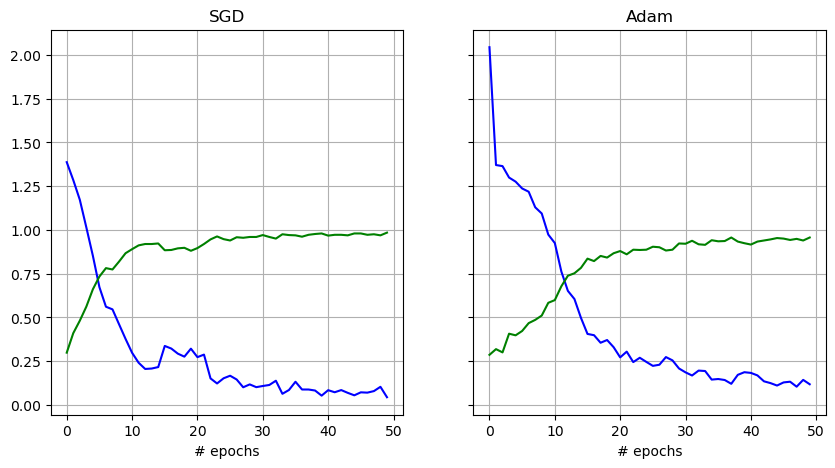

In [38]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))  # 1 row, 2 columns

# First subplot
ax[0].plot(history_sgd.history['loss'], color='blue', label='Training loss')
ax[0].plot(history_sgd.history['accuracy'], color='green', label='Accuracy')
ax[0].grid()
ax[0].set_xlabel("# epochs")
#ax[0].set_ylabel("Training loss")
ax[0].set_title("SGD")

# Second item
ax[1].plot(history_adam.history['loss'], color='blue', label='Training loss')
ax[1].plot(history_adam.history['accuracy'], color='green', label='Accuracy')
ax[1].grid()
ax[1].set_xlabel("# epochs")
#ax[1].set_ylabel("Training loss")
ax[1].set_title("Adam"); 


> Donner le risque de cross-entropy ainsi que la précision pour l'échantillon de test.

In [39]:
my_sgd_CNN.evaluate(X_test, y_test)

6/6 [==============================] - 1s 107ms/step - loss: 4.8616 - accuracy: 0.4815


[4.861627578735352, 0.48148149251937866]

In [40]:
my_adam_CNN.evaluate(X_test, y_test)

6/6 [==============================] - 1s 103ms/step - loss: 4.5869 - accuracy: 0.5309


[4.586865425109863, 0.5308641791343689]

## Matrice de confusion

> Utilisez les outils `classification_report()` et `confusion_matrix()` de `sklearn.metrics` pour décrire les performances du réseau de neurones.

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [42]:
y_pred = my_sgd_CNN.predict(X_test)

6/6 [==============================] - 1s 120ms/step


In [43]:
y_test_not_ohe = y_test.argmax(axis=1)
y_pred_not_ohe = y_pred.argmax(axis=1)

In [44]:
print(classification_report(y_test_not_ohe, y_pred_not_ohe, target_names=names))

              precision    recall  f1-score   support

        cats       0.48      0.60      0.53        55
        dogs       0.25      0.30      0.27        37
      horses       0.57      0.50      0.53        34
      humans       0.89      0.47      0.62        36

    accuracy                           0.48       162
   macro avg       0.55      0.47      0.49       162
weighted avg       0.54      0.48      0.49       162



In [45]:
confusion_matrix(y_test_not_ohe, y_pred_not_ohe)

array([[33, 18,  4,  0],
       [21, 11,  4,  1],
       [ 8,  8, 17,  1],
       [ 7,  7,  5, 17]], dtype=int64)

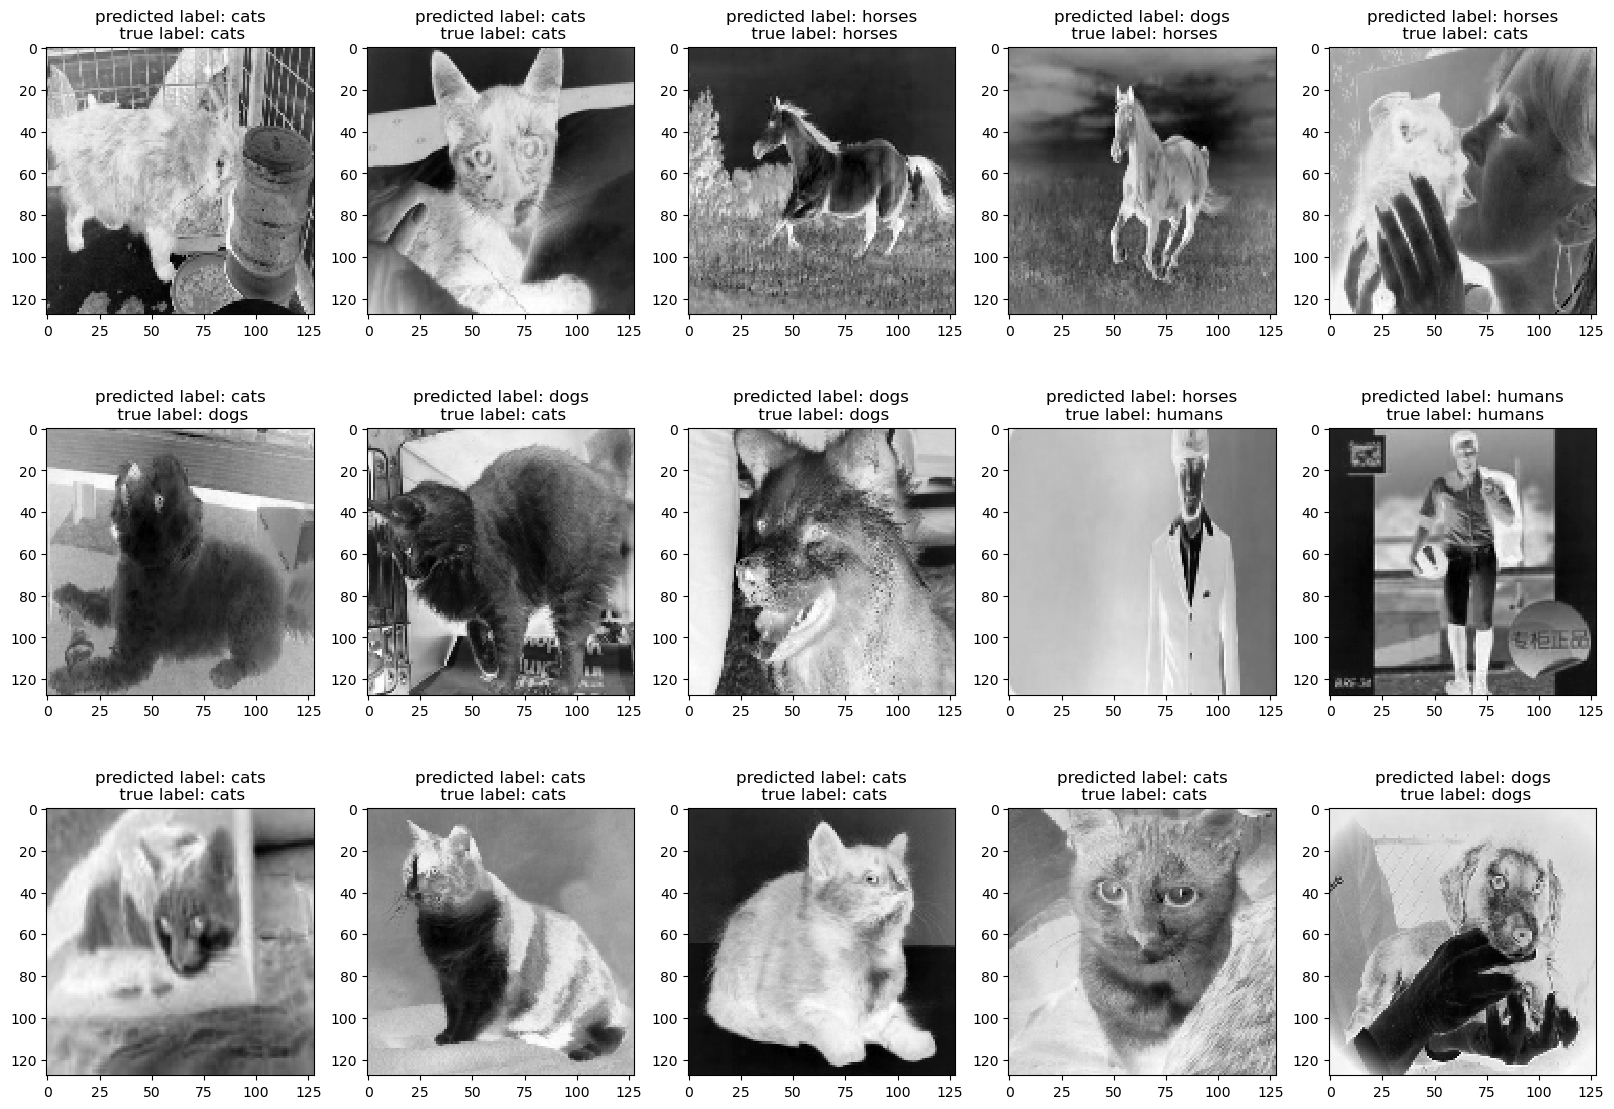

In [46]:
# Visualisation
plt.figure(figsize=(20, 14))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i].reshape(128, 128),
               cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("predicted label: %s\n true label: %s"
              % (names[y_pred_not_ohe[i]], names[y_test_not_ohe[i]]))

Pour afficher la matrice de confusion sous forme graphique, on dispose de la fonction [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) de sklearn. Pour pouvoir utiliser les fonctionnalités de sklearn, il nous faut tout d'abord transformer l'objet Keras en un classifieur sklearn. On peut pour cela utiliser la fonction wrapper [`KerasClassifier`](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasClassifier) du module `keras.wrappers.scikit_learn` (voir aussi le TP précédent).

In [47]:
from keras.wrappers.scikit_learn import KerasClassifier

La fonction `KerasClassifier` est le plus souvent utilisée pour ajuster un réseau, typiquement pour une procédure de type validation croisée (`Gridsearch`). Ici, au contraire, on ne souhaite pas réajuster une nouvelle fois le modèle, mais uniquement changer sa forme. 

> Compléter le code ci-dessous pour créer l'objet `wrapped_model`

In [48]:
def create_model():
    model = Sequential(
    [
        Input(shape=input_shape),  # , batch_size=16
        layers.Conv2D(32, kernel_size=(3, 3), padding="same"),
        layers.ReLU(),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(3, 3), padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
    )
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [49]:
wrapped_model = KerasClassifier(create_model, epochs=50, batch_size=32, verbose=0) 

C:\Users\nicol\AppData\Local\Temp\ipykernel_17568\234352576.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  wrapped_model = KerasClassifier(create_model, epochs=50, batch_size=32, verbose=0)


> Ajuster ce modèle sur les données d'apprentissage. Assurez vous que les prédictions de `wrapped_model` et de `my_first_CNN` sur les données de test sont bien identiques.

In [50]:
wrapped_model.fit(X_train, y_train)

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay  # plot_confusion_matrix is deprecated

In [52]:
y_pred_w = wrapped_model.predict(X_test)

6/6 [==============================] - 1s 114ms/step


In [54]:
ConfusionMatrixDisplay.from_estimator(wrapped_model, X_test, y_test)

ValueError: ConfusionMatrixDisplay.from_estimator only supports classifiers

Cela ne fonctionne pas, il y a en effet un petit bug dans la fonction `KerasClassifier`. En étudiant l'erreur renvoyée ci-dessus, on comprend que la fonction `plot_confusion_matrix` teste si `wrapped_model` est un classifieur, et que le test ici ne passe pas :

In [55]:
from sklearn.base import is_classifier
is_classifier(wrapped_model)

False

Le problème vient du fait que wrapped_model ne possède pas d'attribut "_estimator_type" :

In [56]:
wrapped_model._estimator_type

AttributeError: 'KerasClassifier' object has no attribute '_estimator_type'

> Utiliser la fonction [`setattr`](https://docs.python.org/3/library/functions.html#setattr) pour résoudre ce problème et applique finalement la fonction `plot_confusion_matrix`.

In [57]:
setattr(wrapped_model, '_estimator_type', "classifier")

In [58]:
is_classifier(wrapped_model)

True

Avec la nouvelle version de ConfusionMatrixDisplay, on peut faire ceci :

In [59]:
#https://stackoverflow.com/questions/59165149/plot-confusion-matrix-with-scikit-learn-without-a-classifier

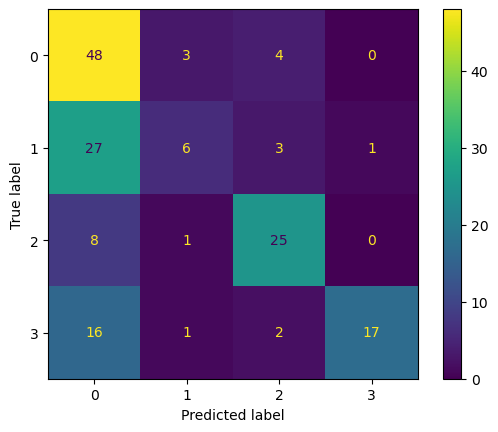

In [60]:
cm = confusion_matrix(y_test_not_ohe, y_pred_w)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=wrapped_model.classes_)
disp.plot()
plt.show()

## Sauvegarde d'un réseau de neurones avec Keras

Lorsqu'un modèle a été ajusté, on peut vouloir conserver 
- l'architecture du réseau
- la valeurs des poids des couches
- l'optimiseur utilisé pour ajuster les poids 
- les métriques et les pertes considérées 

Pour répondre aux questions ci-dessous, vous pourrez consulter cette [page](https://keras.io/guides/serialization_and_saving/) de la documentation qui présente en détail les méthodes pour sauvegarder des réseaux Keras.

##### Sauvegarde du modèle (architecture seule) en json

Dans certaines situations, on ne souhaite sauvegarder que l'architecture. Par exemple si on veut comparer plusieurs méthodes d'optimisation des poids d'un même réseau. Il est possible de sauvegarder l'architecture d'un réseau au format JSON.

JavaScript Object Notation (JSON) est un format de données textuelles dérivé de la notation des objets du langage JavaScript. Il permet de représenter de l’information structurée.

Un document JSON a pour fonction de représenter de l'information accompagnée d'étiquettes permettant d'en interpréter les divers éléments, sans aucune restriction sur le nombre de celles-ci.

Un document JSON ne comprend que deux types d'éléments structurels :
+ Des ensembles de paires "nom" (alias "clé") / "valeur" ;
+ Des listes ordonnées de valeurs.

> Sauver l'architecture du réseau au format json.   
> Afficher le contenu du fichier sauvé.   
> Quelle est la taille du fichier json sur votre disque ?

In [ ]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [61]:
json_config = my_sgd_CNN.to_json()
with open("my_sgd_CNN.json", "w") as json_file:
    json_file.write(json_config)

In [62]:
print(json_config)

{"class_name": "Sequential", "config": {"name": "sequential_3", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_4"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_7", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "ReLU", "config": {"name": "re_lu_6", "trainable": true, "dtype": "float32", "max_value": null, "negative_slope": 0.0, "threshold": 0.0}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8

In [63]:
import os

file_stats = os.stat('my_sgd_CNN.json')

print(file_stats)
print(f'File Size in Bytes is {file_stats.st_size}')
print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

os.stat_result(st_mode=33206, st_ino=8725724279930095, st_dev=3969924142, st_nlink=1, st_uid=0, st_gid=0, st_size=4101, st_atime=1672931661, st_mtime=1672931661, st_ctime=1672931661)
File Size in Bytes is 4101
File Size in MegaBytes is 0.003911018371582031


In [64]:
from keras.models import model_from_json
new_model = model_from_json(json_config)

##### Sauvegarde et chargement du modèle complet entrainé

> Utiliser les fonctions `model.save()` et `load_model()` pour sauver et charger un modèle complet (architecture, poids, optimiseur, métriques). Quelle est la taille du répertoire créé pour cette sauvegarde ?

In [65]:
my_sgd_CNN.save('my_sgd_CNN')

INFO:tensorflow:Assets written to: my_sgd_CNN\assets


INFO:tensorflow:Assets written to: my_sgd_CNN\assets


In [66]:
from keras.models import  load_model
my_sgd_CNN_loaded = load_model('my_sgd_CNN')

> Comparer les poids du réseau reconstruit aux poids du réseau originel.

In [67]:
my_sgd_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 re_lu_6 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 re_lu_7 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 32)        0         
                                                      

In [68]:
my_sgd_CNN_loaded.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 re_lu_6 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 re_lu_7 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 32)        0         
                                                      

In [70]:
my_first_layer_sgd_loaded = my_sgd_CNN_loaded.layers[0]
poids, termes_biais = my_first_layer_sgd_loaded.get_weights()
print(poids.shape)

(3, 3, 1, 32)


In [71]:
my_first_layer_sgd = my_sgd_CNN.layers[0]
poids, termes_biais = my_first_layer_sgd.get_weights()
print(poids.shape)

(3, 3, 1, 32)


> Vérifier que le modèle chargé peut être directement utilisé pour faire des prédictions ou pour calculer un score.

In [74]:
y_predict_from_loaded_model = my_sgd_CNN.predict(X_test)

6/6 [==============================] - 1s 131ms/step


In [75]:
y_predict_from_loaded_model.argmax(axis=1)

array([0, 0, 2, 1, 2, 0, 1, 1, 2, 3, 0, 0, 0, 0, 1, 1, 0, 2, 0, 3, 0, 0,
       1, 2, 3, 2, 0, 0, 0, 0, 1, 3, 0, 1, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0,
       3, 2, 1, 1, 0, 3, 0, 1, 0, 0, 0, 0, 3, 0, 3, 0, 1, 1, 3, 0, 0, 0,
       1, 0, 2, 2, 1, 0, 1, 3, 2, 0, 0, 0, 1, 0, 0, 0, 1, 3, 0, 3, 1, 0,
       1, 3, 1, 0, 0, 0, 2, 1, 3, 0, 2, 2, 2, 0, 0, 2, 3, 0, 0, 0, 2, 1,
       0, 1, 3, 0, 1, 1, 3, 2, 0, 0, 1, 1, 1, 3, 1, 1, 1, 0, 2, 0, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 3, 2, 1, 0, 2, 0,
       0, 1, 1, 0, 1, 0, 2, 1], dtype=int64)

## Bonus : ajustement du modèle sur Google Colab

> Ajuster ce modèle CNN (ou évenuellement un modèle plus profond) sur [Google Colab](https://colab.research.google.com/notebooks) (ou sur [Binder](https://mybinder.org/)). 
> Il vous faudra telecharger les données sur Colab et adapter les codes du TP pour l'importation des images, plusieurs solutions sont possibles, voir par exemple
[ici](https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8]).

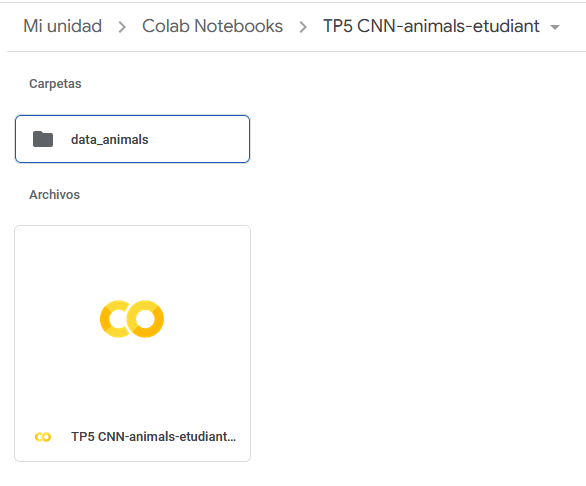

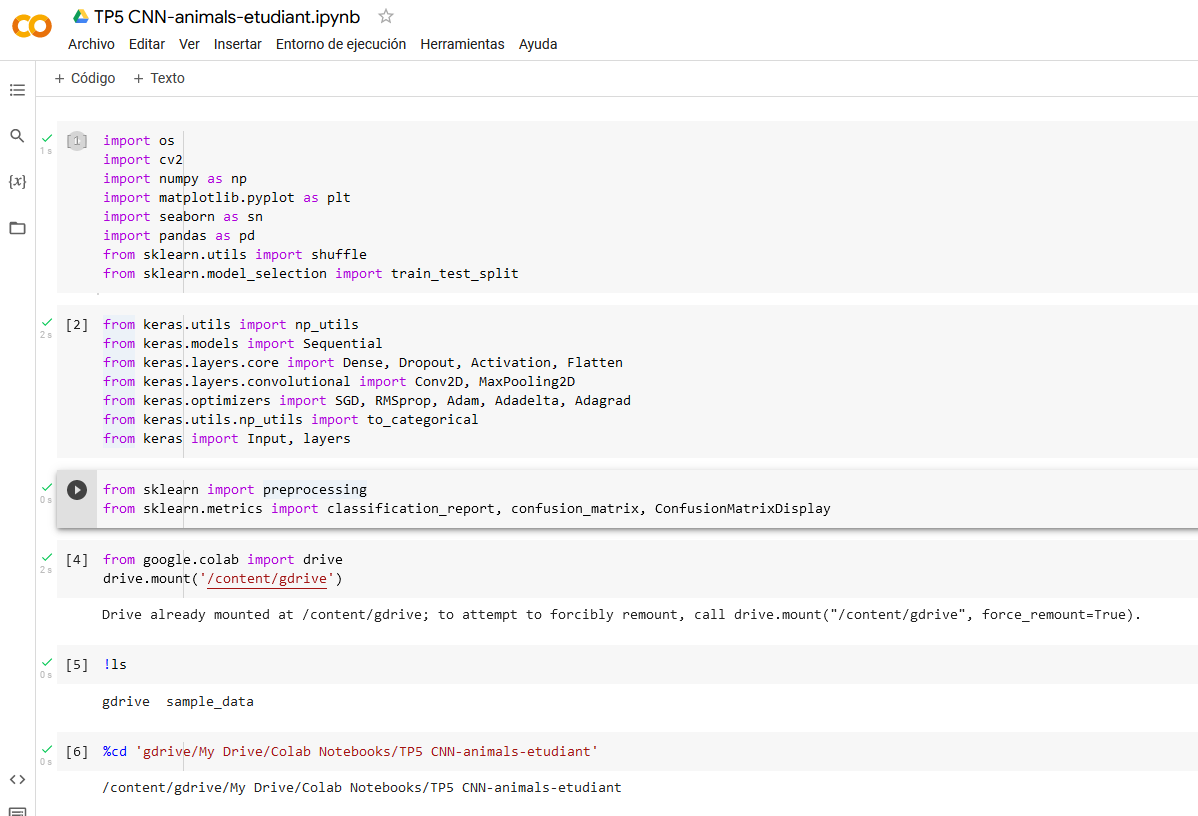

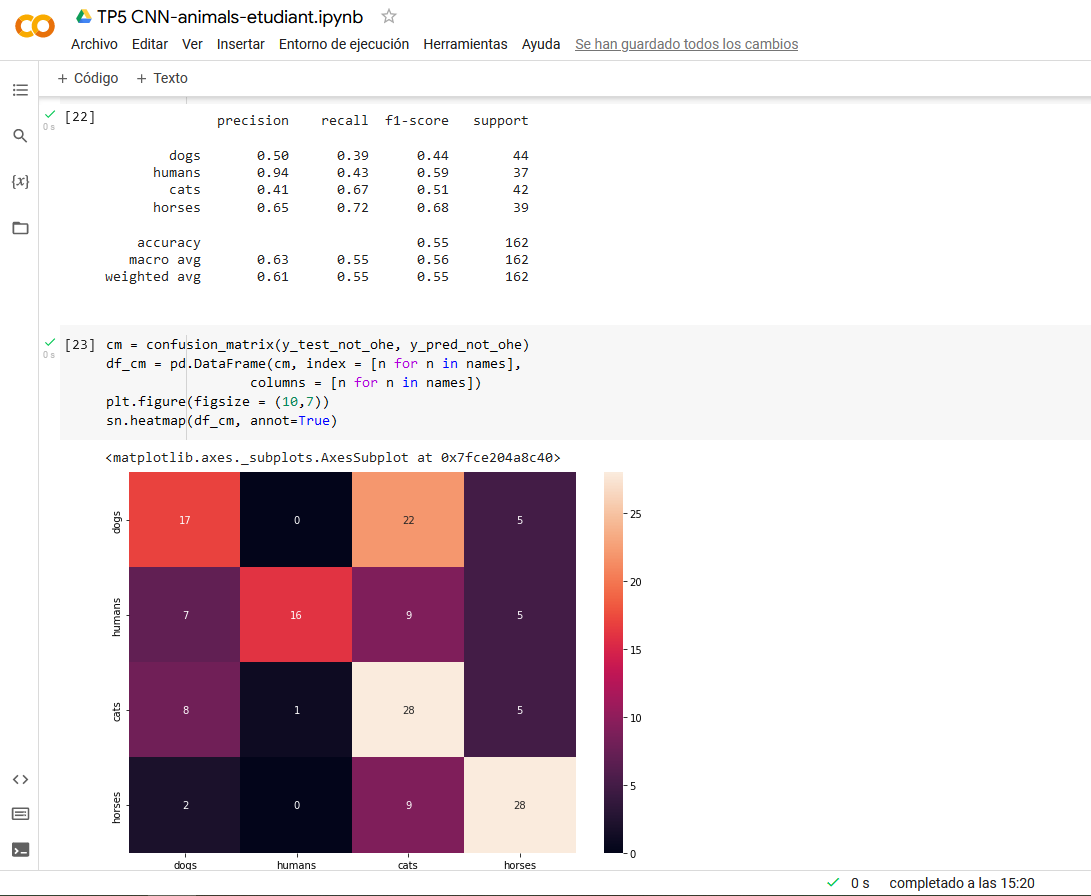

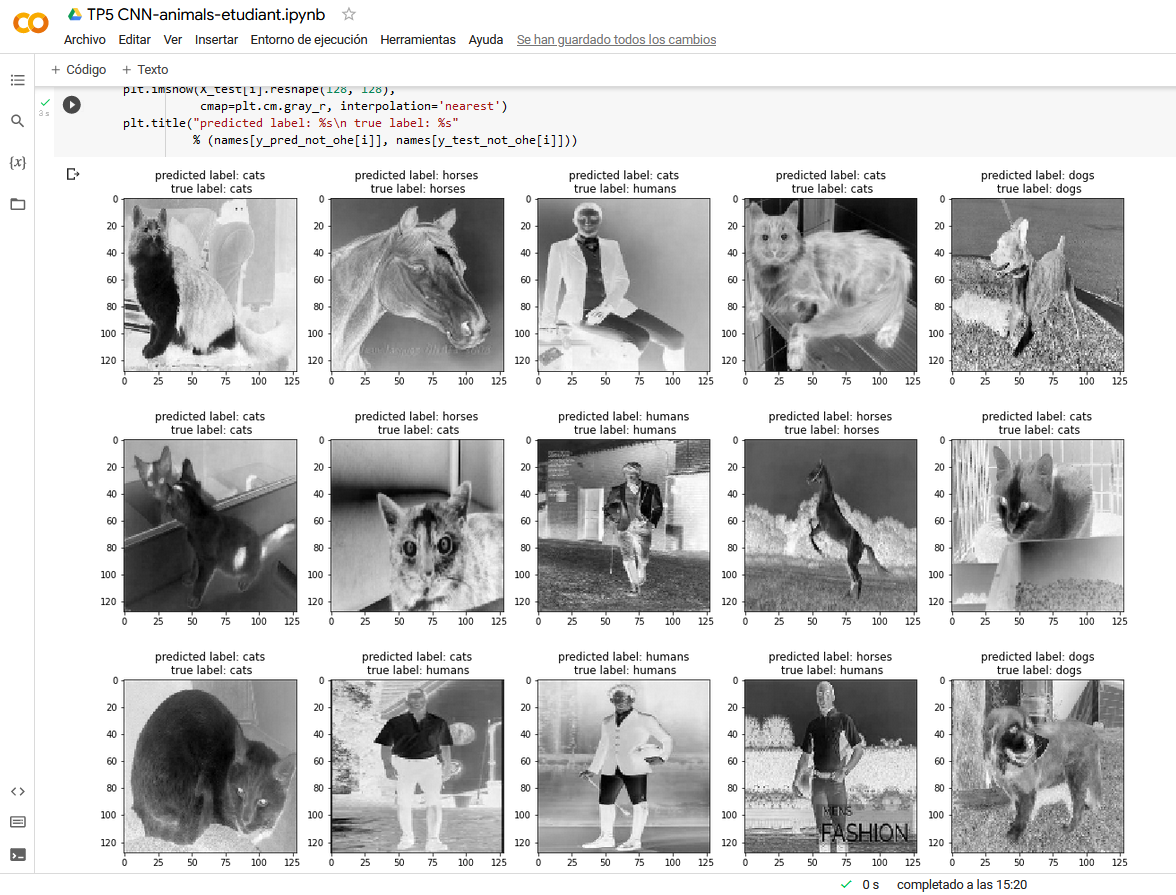